## Mudcard 
- **When we generate local random samples for LIME, how do we determine their target variable value if/when they did not originally exist in the dataset? Do we feed these back into the original model before performing the local modeling?**
    - yes, we use the model to predict the target variable of the random samples
    - we always explain the model predictions
- **For class weights, do we manually calculate those or is the standard to implement sklearn's compute class weights?**
    - I'm not sure what you mean by manually calculating
    - the class_weights in sklearn can be one of the hyperparameters you tune or there are some preset values
- **Will the final exam also cover A/B testing?**
    - sure, anything we cover during the lectures could be part of the final exam

## Deployment and continuous monitoring
By the end of this lecture, you will be able to
- Describe A/B testing and when it's not the right approach to test
- Describe common challenges with deployment
- Develop strategies to monitor a deployed ML model


- you put together the ML pipeline (splitting, preprocessing, parameter tuning)
- tried a couple of supervised ML algorithms
- you have a test score with uncertainty
- feature importance metrics
- you understand and trust your model because of the explanations
- your model's test score seems better than whatever decision-making/prediction process is in place right now
## ... now what?


## It is time to deploy the model!
- up to now you played in a sandbox
   - you worked with historical data
   - no actual decisions were made based on the work you did so far
- once your model is deployed, it will replace whatever decision making process was in place until now
   - this is done carefully and gradually

## Typical scenario
- you get more recent data and you need to apply your model to it (pre-deployment)
- A/B testing (your model is partially deployed)
   - evidence-based comparison of the ML approach and the previous decision making process
- if your model is better than the previous decision making process, your model will replace it (full deployment)

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Describe A/B testing and when it's not the right approach to test**
- <font color='LIGHTGRAY'>Describe common challenges with deployment</font>
- <font color='LIGHTGRAY'>Develop strategies to monitor a deployed ML model</font>


## A/B testing, the concept
- sample A (control group) - labels generated by the current decision-making process (e.g., fraud and not fraud labels predicted based on current decision making process)
- sample B (treatment group) - labels generated by your new ML model
- calculate the evaluation metric of both groups
- for example:
    - accuracy metric is used
    - sample A's accuracy is 90% using 100 points
    - sample B's accuracy is 91% using 100 points
    - is the ML model used to generte sample B's labels significantly better than sample A's decision-making process?
    - what if the labels were calculated for 1000, 1e4, 1e5 points?
    - what if sample B's accuracy is 92%, 95%, 99%?

- more statistics than ML at this point
    - how to select points to each sample?
    - how do I compare the labels of the two samples? what statistical test should I use? 
    - what critical p value should I choose?
    - how many points should I collect per sample? what's a good sample size?

# How to select points for the samples?
- random selection
    - almost never used!
    - if the improvement from control to treatment is small, the evaluation metric might differ mostly because the properties of the points are different in the two samples
- segmentation
    - what groups/segments exist in the population?
    - maybe gender, racial, socio-economic, age, etc
    - determine the distributions of the segments in your overall population
    - make sure that each segment is equally well represented in the two samples you create

# What  statistical test should I use?
- this is beyond what I can cover in one lecture
- look for stats courses offered at Brown or online courses on A/B testing
- check out this [page](https://www.inferentialthinking.com/chapters/12/1/AB_Testing.html)
- here is a nice [flowchart](http://www.statsflowchart.co.uk/)

# What critical p value should I choose?
- p value: it is the probability that the treatment group's property of interest (the value of the evaluation metric in our case) is similar to the control group's.
- null hypothesis: the measured property of the two groups is similar
- large p value: the null hypothesis is correct
- small p value: the null hypothesis can be rejeted with some certainity
- most often used critical p values are 0.01 and 0.05.

# Estimate the sample size
- how many points should be in the control and treatment groups?
- answer the following questions:
    - what is the value of the evaluation metric in the control group?
    - what is the test score of your new ML model?
        - that's the expected performance of your model on new data points
    - the difference between the two scores is what you want to measure
    - what test is the best to use?
    - what's your crtitical p value?
- once you know these answers, you can code a simple model to estimate the sample size

In [1]:
import numpy as np
import scipy.stats as stats
np.random.seed(0)
n_samples = [400, 800, 1200, 1600, 2000] # sample size in a segment
A_acc = 0.8 # accuracy in the control group
B_acc = 0.85 # expected accuracy in the treatment group

# let's loop through n, simulate data, apply t test to simulated data
median_p = np.zeros(len(n_samples))
upper_p = np.zeros(len(n_samples))
lower_p = np.zeros(len(n_samples))
for n in range(len(n_samples)):
    p_vals = []
    for i in range(100): # generate 100 random samples
        A_results = np.random.choice([0, 1], size=(n_samples[n]), p=[1-A_acc, A_acc])
        B_results = np.random.choice([0, 1], size=(n_samples[n]), p=[1-B_acc, B_acc])
        oddsratio, pvalue = stats.fisher_exact([[sum(A_results==0), sum(A_results==1)], [sum(B_results==0), sum(B_results==1)]])
        p_vals.append(pvalue)
        
    median_p[n] = np.median(p_vals)
    upper_p[n] = np.percentile(p_vals,84) # you can also do np.max(p_vals)
    lower_p[n] = np.percentile(p_vals,16) # you can also do np.min(p_vals)


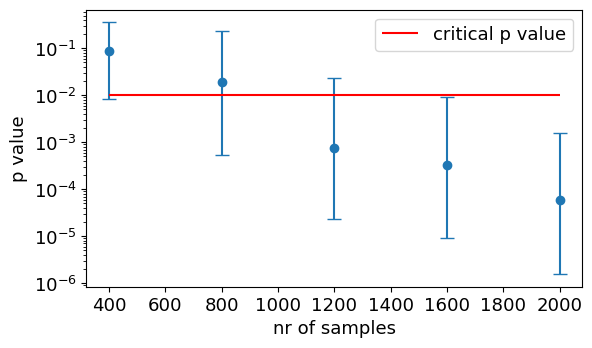

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,3.6))
plt.errorbar(n_samples,median_p,yerr=np.array([median_p-lower_p,upper_p-median_p]),capsize=5,fmt='o')
plt.hlines(0.01,n_samples[0],n_samples[-1],color='r',label='critical p value')
plt.xlabel('nr of samples')
plt.ylabel('p value')
plt.semilogy()
plt.legend()
plt.show()

## Quiz

## A/B testing - example
**My project with Advancement**
- goal: predict how much alumni will donate in the upcoming fiscal year
   - the predictions are used as target ask amounts in phone/mail/email communication
- previous decision making process:
   - a group of experts meet regularly for a couple of weeks to discuss what a good target ask amount is
   - very labor-intensive and also somewhat subjective
- a regression model was developed by my colleague and myself with R2 scores in the range of 0.7-0.8
- it was time to test it

## A/B testing - example
- Advancement created two groups:
   - group A (control) - the previous decision making process was used to generate target ask amounts
   - group B (treatment) - the regression model's prediction were used
- alumni were randomly assigned to the two groups
   - we checked that key demographic groups (race/gender/ethnicity) were more or less evenly distributed in the two groups
- the only difference between the two groups were the decision making process used, everything else was the same.
- we waited a year :D

## A/B testing - example
- we compared the donations given by the two groups using statistical tests
   - we used a two sided t test to compare the donation distributions in groups A and B
- unfortunately we found that my model does not increase the amount the alumni donate 
- the model was still adopted by Advancement because it saves a ton of work for them
   - several people's work time freed up so they can do better, more important things now
- this year, my model completely replaced Advancement's previous decision making process

## A/B testing - when it is not the right approach
- testing is not always ethical
   - [facebook scandal](https://techcrunch.com/2014/06/29/ethics-in-a-data-driven-world/)
   - you need approval from Ethics Board or IRB
- testing is approved but you want to minimize variations in user experience 
   - you shouldn't ask different users to pay different amounts for the same service
   - they will start to complain :)
   - multi-armed bandit is a good alternative to minimize costs like this (read about it [here](https://en.wikipedia.org/wiki/Multi-armed_bandit) and [here](https://towardsdatascience.com/when-and-when-not-to-a-b-test-c901f3ad96d9))

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe A/B testing and when it's not the right approach to test</font>
- **Describe common challenges with deployment**
- <font color='LIGHTGRAY'>Develop strategies to monitor a deployed ML model</font>


## Once the model is tested and deployed, you are not done
- incoming data properties can change
   - feature distributions could slowly move away from what you had in training
   - category ratios could change
   - new classes could appear
   - outliers in regression could become the new norm

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe A/B testing and when it's not the right approach to test</font>
- <font color='LIGHTGRAY'>Describe common challenges with deployment</font>
- **Develop strategies to monitor a deployed ML model**

## What to do?
- incoming data needs to be monitored
- keep an eye on feature statistics and the target variable properties
- if you see the data changing, retrain your model

# Mudcard

In [6]:
np.arange(0.1,1.1,0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])